In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import scipy.signal
import mne
from itertools import cycle
import matplotlib.pyplot as plt
import os.path

mpl.rcParams['figure.max_open_warning'] = 30

select results file and get necessary parameters

In [2]:
# baseline = None
#resfile = os.path.join(helpers.resultsdir, 'meg_singledot_201706121047.h5')

# baseline = (-0.3, 0)
resfile = os.path.join(helpers.resultsdir, 'meg_singledot_201706131051.h5')

# source GLM, baseline (-0.3, 0), no permutations
#resfile = os.path.join(helpers.resultsdir, 'source_singledot_201706161257.h5')

# source GLM, baseline (-0.3, 0), only basic regressors
#resfile = os.path.join(helpers.resultsdir, 'source_singledot_201706221206.h5')

#evoked = helpers.load_evoked_container(window=pd.read_hdf(resfile, 'window'))
evoked = helpers.load_evoked_container(window=[0, 0.9])

Reading data/meg_final_data/evoked_sfreq100.0_window0.00-0.90_mag-ave.fif ...
    Found the data of interest:
        t =       0.00 ...     890.00 ms (Unknown)
        0 CTF compensation matrices available
        nave = 480 - aspect type = 100
No baseline correction applied


plotting functions

In [12]:
stylecycler = cycle([':', '--', '-.'])
def plot_minmax_regressors(results, r_names, measure, nperm=0, mode='absmax', ax=None):
    if mode == 'max':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').max(
            level='time').plot(y=r_names, ax=ax);
    elif mode == 'min':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').min(
            level='time').abs().plot(y=r_names, ax=ax);
    elif mode == 'absmax':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).max(level='time').plot(y=r_names, ax=ax)
    elif mode == 'absmean':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).mean(level='time').plot(y=r_names, ax=ax)
        
    cols = [l.get_color() for l in ax.get_lines()]

    nperm += 1
    
    for perm in perms[1:nperm]:
        if mode == 'max':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').max(
                level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'min':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').min(
                level='time').abs().plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmax':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).max(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmean':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).mean(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))

    lines = ax.get_lines()
    for i in range(len(r_names)):
        col = lines[i].get_color()
        for perm in perms[1:nperm]:
            lines[i + perm * len(r_names)].set_color(col)
            
def show_topology_at_peaks(results, r_name, measure, mode='absmax', order=4, vmin=-.1, vmax=.1):
    if mode == 'absmax':
        data = results.loc[0, (measure, r_name)].abs().max(level='time')
    elif mode == 'absmean':
        data = results.loc[0, (measure, r_name)].abs().mean(level='time')
    elif mode == 'max':
        data = results.loc[0, (measure, r_name)].max(level='time')
    else:
        data = results.loc[0, (measure, r_name)].min(level='time').abs()
    
    plt.figure()
    ax = data.plot(title=measure);
    
    # identify local maxima
    times = data.index[scipy.signal.argrelextrema(data.values, 
                                                  np.greater, order=order)] / 1000
    
    data = results.loc[0, (measure, r_name)]
    ev = mne.EvokedArray(data.values.reshape(102, data.index.levels[1].size), 
                         evoked.info, tmin=data.index.levels[1][0], 
                         nave=480*5, comment=r_name)
    
    fig = ev.plot_topomap(times, scale=1, vmin=vmin, vmax=vmax, image_interp='nearest', 
                          title=r_name+' aligned to dot onset', unit=measure, 
                          outlines='skirt');
    
def plot_single_signal(fl_data, sl_data, label, r_name, ax=None):
    dat = fl_data.loc[(0, label, slice(None)), 
                      (slice(None), 'beta', r_name)]
    times = dat.index.get_level_values('time')
    
    if ax is None:
        fig, ax = plt.subplots()
        
    l = ax.plot(times, dat, color='.7', label='single subjects')
    l1 = ax.plot(times, sl_data.loc[(slice(1,3), label, slice(None)), ('mean', r_name)]
                               .reset_index('permnr')
                               .pivot(columns='permnr'), 
                 ':k', label='mean (permuted data)')
    l2 = ax.plot(times, sl_data.loc[(0, label, slice(None)), ('mean', r_name)], 
                 'k', lw=2, label='mean')
    
    ax.legend([l[0], l1[0], l2[0]], ['single subjects', 'mean (permuted data)', 'mean']);
    ax.set_title(label)
    ax.set_xlabel('time from dot onset (ms)')
    ax.set_ylabel('beta of ' + r_name + ' (z)')

# Second level analysis

In [3]:
store = pd.HDFStore(resfile, 'r')

In [4]:
store.keys()

['/bl',
 '/dots',
 '/epochs_mean',
 '/epochs_std',
 '/first_level',
 '/first_level_diagnostics',
 '/scalar_params',
 '/second_level',
 '/window']

In [14]:
second_level = store.second_level
perms = second_level.index.levels[0]

In [22]:
second_level.columns.levels[1]

Index(['abs_dot_x_1', 'abs_dot_x_2', 'abs_dot_x_3', 'abs_dot_x_4',
       'abs_dot_x_5', 'abs_dot_y_1', 'abs_dot_y_2', 'abs_dot_y_3',
       'abs_dot_y_4', 'abs_dot_y_5', 'dot_x_1', 'dot_x_2', 'dot_x_3',
       'dot_x_4', 'dot_x_5', 'dot_x_cflip_1', 'dot_x_cflip_2', 'dot_x_cflip_3',
       'dot_x_cflip_4', 'dot_x_cflip_5', 'dot_y_1', 'dot_y_2', 'dot_y_3',
       'dot_y_4', 'dot_y_5', 'entropy', 'intercept', 'response', 'trial_time'],
      dtype='object', name='regressor')

In [10]:
second_level.head()

measure                    mean                                      \
regressor           abs_dot_x_1 abs_dot_x_2 abs_dot_x_3 abs_dot_x_4   
permnr channel time                                                   
0      MEG0111 0      -0.001070   -0.006089    0.000860   -0.000210   
               10      0.003999    0.000118   -0.000988   -0.003814   
               20     -0.000465    0.000076   -0.006579   -0.007675   
               30     -0.006153    0.005496   -0.004913   -0.013858   
               40     -0.003306    0.012932    0.011966   -0.017495   

measure                                                              \
regressor           abs_dot_x_5 abs_dot_y_1 abs_dot_y_2 abs_dot_y_3   
permnr channel time                                                   
0      MEG0111 0      -0.004562   -0.017904   -0.005188   -0.012631   
               10      0.007177   -0.010531   -0.001601   -0.004194   
               20      0.001245   -0.002913   -0.003285    0.005071   
               30     -0.005946    0.001524   -0.003752   -0.002201   
               40     -0.007067    0.000180   -0.000037   -0.007579   

measure                                        ...               std  \
regressor           abs_dot_y_4 abs_dot_y_5    ...     dot_x_cflip_5   
permnr channel time                            ...                     
0      MEG0111 0       0.009026   -0.004380    ...          0.046960   
               10      0.000409    0.001361    ...          0.049919   
               20     -0.003088    0.000282    ...          0.057575   
               30     -0.003109    0.004695    ...          0.054634   
               40     -0.002673    0.007552    ...          0.046858   

measure                                                                \
regressor             dot_y_1   dot_y_2   dot_y_3   dot_y_4   dot_y_5   
permnr channel time                                                     
0      MEG0111 0     0.036136  0.038724  0.038285  0.032736  0.041748   
               10    0.039714  0.040345  0.041569  0.044012  0.037033   
               20    0.047156  0.040395  0.045485  0.047170  0.046145   
               30    0.046271  0.040180  0.055466  0.054154  0.047327   
               40    0.049189  0.036076  0.051663  0.057962  0.040873   

measure                                                       
regressor             entropy intercept  response trial_time  
permnr channel time                                           
0      MEG0111 0     0.102297  0.103559  0.046886   0.046366  
               10    0.102850  0.108761  0.065446   0.041092  
               20    0.099026  0.103414  0.059923   0.050461  
               30    0.105092  0.118909  0.049690   0.052407  
               40    0.109874  0.123152  0.056419   0.051901  

[5 rows x 87 columns]

In [4]:
second_level = pd.read_hdf(resfile, 'second_level')

with open('/proc/meminfo') as memfile:
    freemem = -1
    while freemem < 0:
        line = memfile.readline()
        if line.startswith('MemAvailable:'):
            freemem = int(line.split()[1])

# if there is at least 3.5 GB of RAM available
if freemem > 2500000:
    first_level = pd.read_hdf(resfile, 'first_level')

perms = second_level.index.levels[0]

#dots = pd.read_hdf(resfile, 'dots')
dots = np.arange(5)+1

# Note that these are not exactly the t-values underlying the negative log10 p-values 
# stored in second_level, because scipy.stats uses a different denominator when 
# computing variances and standard deviations than the default used by numpy 
# (N-1 in scipy.stats vs. N in numpy default).
tvals = (second_level.xs('mean', axis=1, level='measure')  / 
         second_level.xs('std', axis=1, level='measure') * np.sqrt(34))

### describe genuine regressors

In [5]:
measure = 'mean'

second_level.xs(measure, axis=1, level='measure').xs(0, level='permnr').describe()

regressor,abs_dot_x_1,abs_dot_x_2,abs_dot_x_3,abs_dot_x_4,abs_dot_x_5,abs_dot_y_1,abs_dot_y_2,abs_dot_y_3,abs_dot_y_4,abs_dot_y_5,...,dot_x_5,dot_y_1,dot_y_2,dot_y_3,dot_y_4,dot_y_5,entropy,intercept,response,trial_time
count,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,...,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000
mean,0.000005,-0.000159,-0.000068,0.000154,0.000389,-0.000305,0.000100,-0.000222,0.000125,-0.000339,...,-0.000086,-0.000226,0.000105,0.000111,0.000083,0.000065,-0.000039,0.001345,-0.000144,-0.000164
std,0.008304,0.008516,0.008015,0.008738,0.007926,0.008034,0.007812,0.007545,0.008115,0.007861,...,0.010009,0.008580,0.008007,0.008230,0.008067,0.008510,0.013347,0.026804,0.009747,0.013976
min,-0.038141,-0.041702,-0.048210,-0.051964,-0.037056,-0.040039,-0.034818,-0.039540,-0.040766,-0.037579,...,-0.075326,-0.056743,-0.037253,-0.047135,-0.036679,-0.038476,-0.066156,-0.127334,-0.061821,-0.084627
25%,-0.005155,-0.005398,-0.004953,-0.005357,-0.004535,-0.005426,-0.004788,-0.004794,-0.004955,-0.005163,...,-0.005581,-0.005320,-0.004732,-0.004886,-0.004920,-0.005138,-0.008441,-0.013428,-0.005777,-0.008597
50%,0.000015,-0.000206,-0.000035,0.000067,0.000392,-0.000374,0.000067,-0.000095,0.000164,-0.000239,...,0.000013,-0.000175,0.000058,-0.000065,0.000067,0.000069,-0.000118,0.001240,-0.000219,0.000094
75%,0.005056,0.005159,0.004869,0.005607,0.005332,0.004760,0.004983,0.004478,0.005279,0.004661,...,0.005387,0.004936,0.004939,0.005007,0.005000,0.005273,0.008300,0.016560,0.005631,0.008401
max,0.038304,0.042440,0.037068,0.060828,0.037519,0.034103,0.038100,0.032706,0.034364,0.038555,...,0.070554,0.066487,0.039813,0.049986,0.041304,0.038411,0.057729,0.147036,0.048659,0.076464


### describe regressors of first permutation

In [6]:
second_level.xs(measure, axis=1, level='measure').xs(1, level='permnr').describe()

regressor,abs_dot_x_1,abs_dot_x_2,abs_dot_x_3,abs_dot_x_4,abs_dot_x_5,abs_dot_y_1,abs_dot_y_2,abs_dot_y_3,abs_dot_y_4,abs_dot_y_5,...,dot_x_5,dot_y_1,dot_y_2,dot_y_3,dot_y_4,dot_y_5,entropy,intercept,response,trial_time
count,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,...,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000,32580.000000
mean,-0.000006,-0.000032,0.000054,0.000026,-0.000037,0.000001,-0.000044,-0.000004,0.000010,-0.000015,...,-0.000005,0.000014,0.000043,0.000037,0.000044,0.000004,-0.000006,0.000942,-0.000018,0.000004
std,0.008143,0.008384,0.007983,0.008041,0.007369,0.008027,0.007579,0.007836,0.007915,0.008014,...,0.007702,0.008123,0.007854,0.007974,0.008151,0.008030,0.012563,0.027023,0.008740,0.007064
min,-0.038519,-0.041595,-0.038660,-0.037457,-0.034409,-0.042330,-0.034933,-0.036826,-0.041253,-0.038792,...,-0.038775,-0.038634,-0.037388,-0.042765,-0.041759,-0.036063,-0.059980,-0.141849,-0.042977,-0.036394
25%,-0.005052,-0.005189,-0.004855,-0.004988,-0.004590,-0.005040,-0.004732,-0.004766,-0.004879,-0.005002,...,-0.004755,-0.005024,-0.004741,-0.004883,-0.004998,-0.004936,-0.007799,-0.013896,-0.005427,-0.004377
50%,0.000040,-0.000055,0.000066,0.000006,-0.000039,0.000004,-0.000018,0.000008,-0.000006,0.000028,...,-0.000013,0.000071,0.000049,-0.000011,0.000077,-0.000010,-0.000075,0.001070,0.000031,0.000030
75%,0.005011,0.005058,0.004940,0.004989,0.004521,0.004991,0.004698,0.004755,0.004965,0.005002,...,0.004729,0.005063,0.004826,0.004851,0.005061,0.004924,0.007710,0.016346,0.005418,0.004353
max,0.039096,0.040044,0.045997,0.035954,0.037570,0.034260,0.038083,0.035770,0.037861,0.036355,...,0.034598,0.037284,0.038005,0.038086,0.036992,0.040200,0.057817,0.142813,0.040635,0.032334


## Show evolution of max (across channels) through the trial

<IPython.core.display.Javascript object>


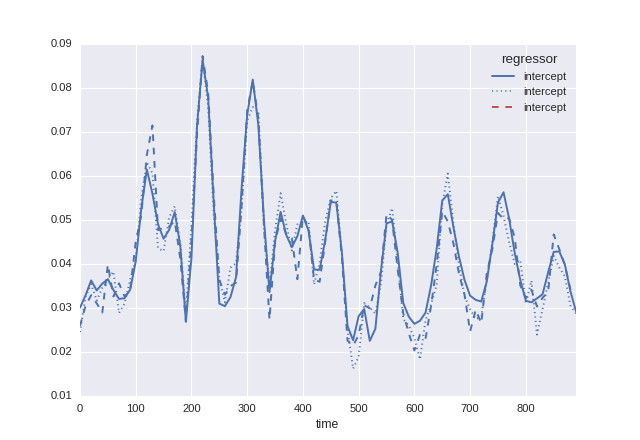

In [15]:
reg = ['intercept']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

<IPython.core.display.Javascript object>


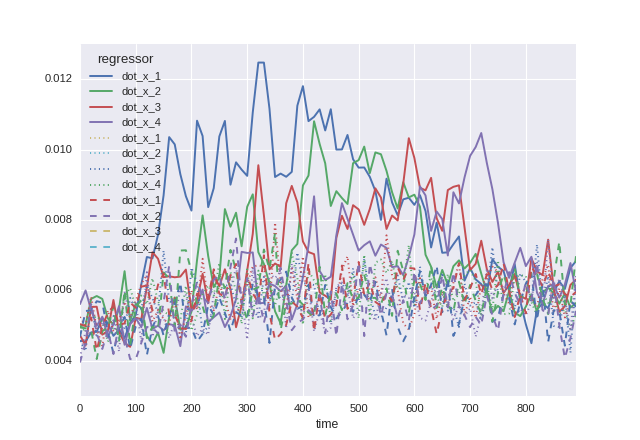

In [7]:
reg = ['dot_x_1', 'dot_x_2', 'dot_x_3', 'dot_x_4']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

trial-wise regressors

<IPython.core.display.Javascript object>


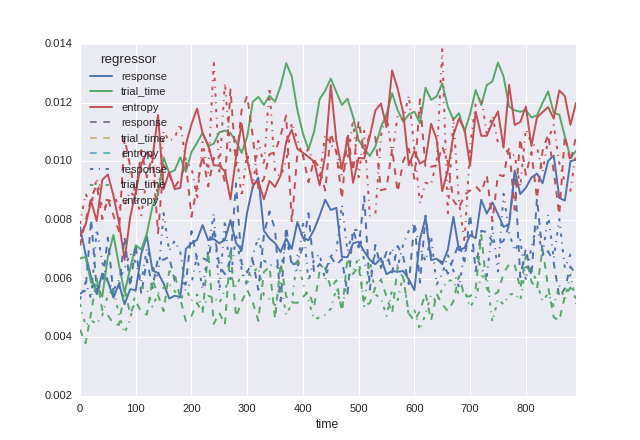

In [11]:
reg = ['response', 'trial_time', 'entropy']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

In [101]:
reg = 'trial_time'
labels = second_level.xs(0, level='permnr').abs().mean(level='label')[(measure, reg)].sort_values(ascending=False)
labels.iloc[:20]

label
L_VMV2_ROI-lh     0.041351
L_TPOJ2_ROI-lh    0.038440
R_47m_ROI-rh      0.030407
R_IFSp_ROI-rh     0.028878
R_FOP4_ROI-rh     0.025230
R_24dv_ROI-rh     0.024175
R_45_ROI-rh       0.023123
L_V3CD_ROI-lh     0.022959
L_TPOJ1_ROI-lh    0.022805
R_24dd_ROI-rh     0.022579
L_p24pr_ROI-lh    0.022505
L_6d_ROI-lh       0.022110
R_IFJp_ROI-rh     0.021953
L_VMV1_ROI-lh     0.021726
L_7Pm_ROI-lh      0.021340
L_VVC_ROI-lh      0.021277
R_LO1_ROI-rh      0.020972
R_p24_ROI-rh      0.020671
L_POS1_ROI-lh     0.020464
R_IFJa_ROI-rh     0.020436
Name: (mean, trial_time), dtype: float64

<IPython.core.display.Javascript object>


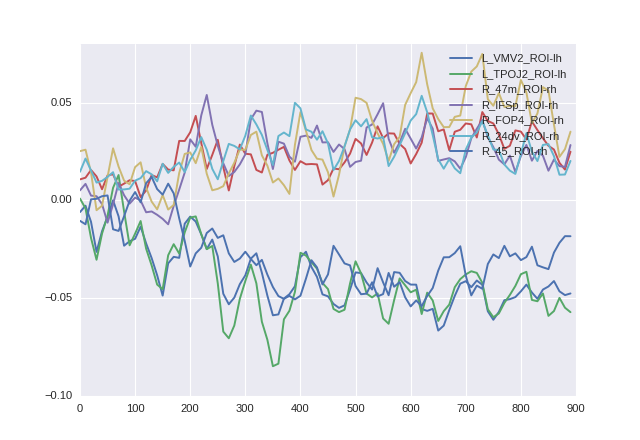

In [102]:
Ntop = 7
fig, ax = plt.subplots()
ax.plot(second_level.index.levels[2], 
        second_level.loc[(0, labels.iloc[:Ntop].index, slice(None)), (measure, reg)]
        .reset_index(level='label').pivot(columns='label'))
ax.legend(labels.iloc[:Ntop].index);

## Dot-specific effects in single channel / label

<IPython.core.display.Javascript object>


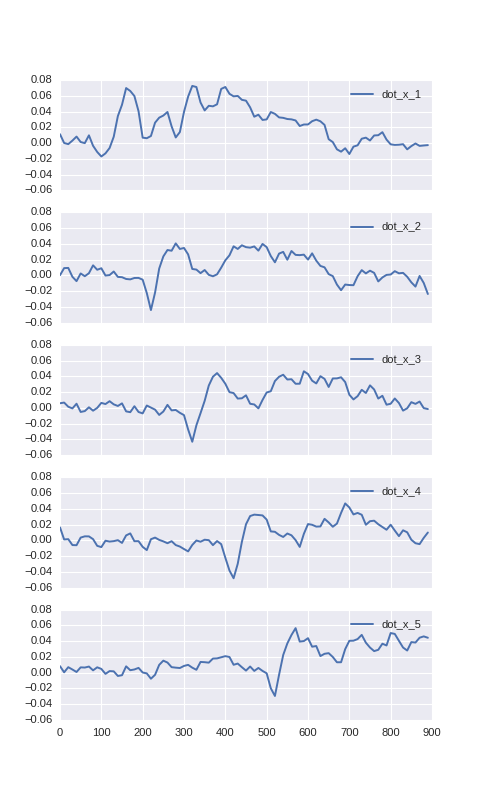

In [12]:
r_name = 'dot_x'
regs = ['{}_{}'.format(r_name, d) for d in dots]
R = len(regs)

measure = 'mean'
label = 'R_v23ab_ROI-rh'

fig, axes = plt.subplots(R, 1, sharex=True, sharey=True, figsize=[6, 10])

times = second_level.index.levels[2]
for r, reg in enumerate(regs):
    axes[r].plot(times, second_level.loc[(0, label, slice(None)), (measure, reg)])
    axes[r].legend([reg])

<IPython.core.display.Javascript object>


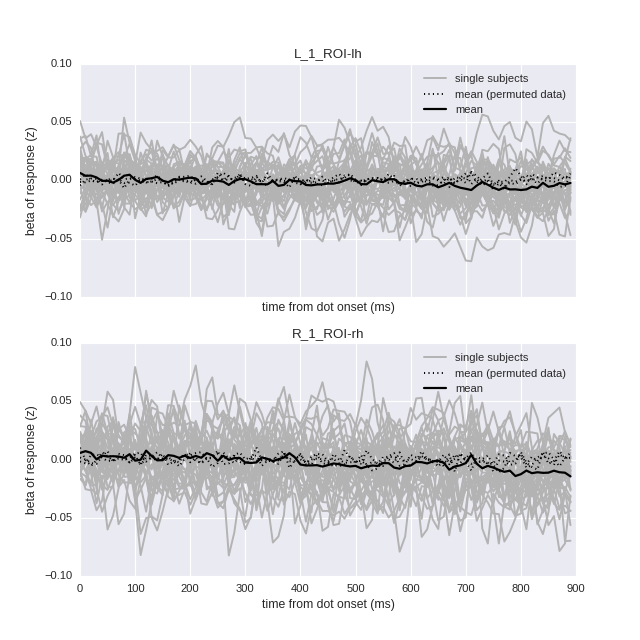

In [8]:
r_name = 'response'
area = '1'
fig, axes = plt.subplots(2, 1, sharey=True, sharex=True, figsize=[8, 8])
plot_single_signal(first_level, second_level, 'L_%s_ROI-lh'%area, r_name, axes[0])
plot_single_signal(first_level, second_level, 'R_%s_ROI-rh'%area, r_name, axes[1])
axes[1].set_ylim([-0.1, 0.1]);

## plot dot regressors individually, but aligned to dot onset

<IPython.core.display.Javascript object>


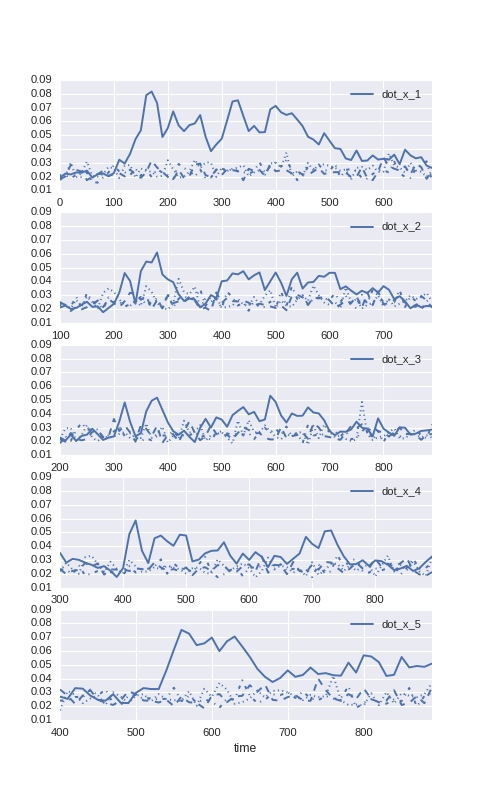

In [13]:
win = [0, 0.69]
r_name = 'dot_x'
measure = 'mean'

regs = ['{}_{}'.format(r_name, d) for d in dots]
R = len(regs)

fig, axes = plt.subplots(R, 1, sharex=False, sharey=True, figsize=[6, 10])

for r, reg in enumerate(regs):
    times = slice(int(100*r + win[0]*1000), int(100*r + win[1]*1000))
    plot_minmax_regressors(second_level.loc[(slice(None), slice(None), times), :], 
                           [reg], measure, nperm=5, mode='absmax', ax=axes[r])
    axes[r].legend([reg])
    

for a single channel / label

<IPython.core.display.Javascript object>


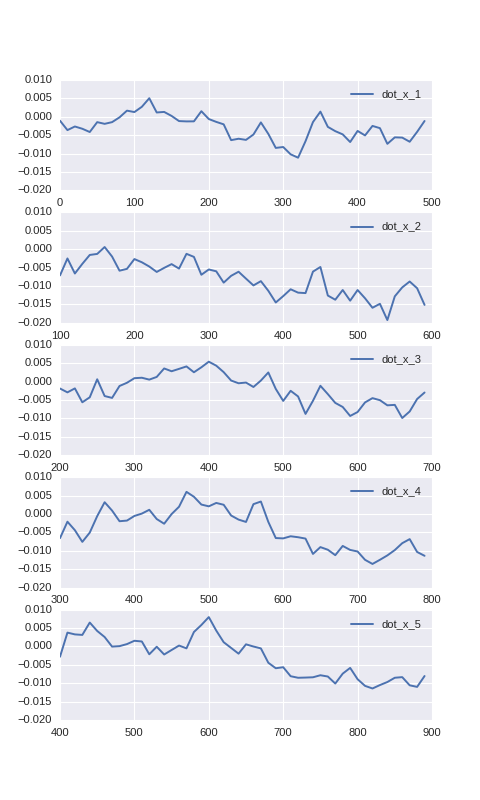

In [30]:
win = [0, 0.49]
r_name = 'dot_x'
measure = 'mean'
label = 'R_1_ROI-rh'

regs = ['{}_{}'.format(r_name, d) for d in dots]
R = len(regs)

fig, axes = plt.subplots(R, 1, sharex=False, sharey=True, figsize=[6, 10])

for r, reg in enumerate(regs):
    times = slice(int(100*r + win[0]*1000), int(100*r + win[1]*1000))
    timesa = np.arange(times.start, times.stop+10, 10)
    axes[r].plot(timesa, second_level.loc[(0, label, times), (measure, reg)])
    axes[r].legend([reg])
    

## plot topography of chosen regressor at chosen time point

<IPython.core.display.Javascript object>


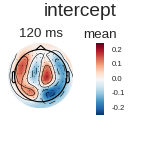

In [32]:
reg = 'intercept'
measure = 'mean'
time = 0.12

data = second_level.loc[(0, slice(None), time*1000), (measure, reg)]

ev = mne.EvokedArray(data.values[:, None], 
                     evoked.info, tmin=time, 
                     nave=480, comment=reg)

fig = ev.plot_topomap(time, scale=1, vmin=-0.2, vmax=0.2, image_interp='nearest', 
                      title=reg, unit=measure, outlines='skirt');